In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

from utils.nets import *
from utils.model_tools import *
from utils.feature_extractor import *
from utils.dataset_tools import *
from utils.cosine_similarity import *

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants

LEARNING_RATE = 0.001 # Different for CIFAR100
EXP_DECAY = 0.0001

batch_size = 64

# Files
CIFAR10_model_file = "./logs/cifar_10_cnn.pt"
FNIST_model_no_boot_bag_file = "./logs/fnist_no_boot_bag.pt"
VGG11_model_file = "./logs/vgg11.pt"
VGG19_model_file = "./logs/vgg19.pt"

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
# Loading general CIFAR10 trainsets/testsets
CIFAR10_train_gen = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR10_trainloader_gen = torch.utils.data.DataLoader(CIFAR10_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

CIFAR10_test_gen = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
CIFAR10_testloader_gen = torch.utils.data.DataLoader(CIFAR10_test_gen, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

CIFAR10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# In the paper, the classes left out are 'cat' and 'car'; 'cat' is added back in later

CIFAR10_cnn = CIFAR10Cnn(8)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# Filtering classes from CIFAR10

# Creates dataloader without cat and car (indices 1 and 3) classes
no_cat_car_idx = np.where((np.array(CIFAR10_train_gen.targets) != 1) & (np.array(CIFAR10_train_gen.targets) != 3))[0]
no_cat_car_subset = torch.utils.data.Subset(CIFAR10_train_gen, no_cat_car_idx)
no_cat_car_dl = torch.utils.data.DataLoader(no_cat_car_subset, batch_size=batch_size, shuffle=True, num_workers=2)

# Dataloader for everything but car
no_car_idx = np.where((np.array(CIFAR10_train_gen.targets) != 1))[0]
no_car_subset = torch.utils.data.Subset(CIFAR10_train_gen, no_car_idx)
no_car_dl = torch.utils.data.DataLoader(no_car_subset, batch_size=batch_size, shuffle=True, num_workers=2)

# TODO: make a nice little function for this
# TODO: be able to create subsets with certain amounts of classes combined
# not sure if there's an official way but
# could also just get idx of classes and then take random indexes, or maybe there's a way to do that with subset


In [6]:
vgg11 = torchvision.models.vgg11(progress=True)
vgg19 = torchvision.models.vgg19(progress=True)

In [ ]:
# CIFAR100 dataset for VGG11 and VGG19

CIFAR100_train_gen = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR100_trainloader_gen = torch.utils.data.DataLoader(CIFAR100_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Filtering last 10 classes from CIFAR 100

# Creates dataloader without cat and car (indices 1 and 3) classes
first_90_idx = np.where((np.array(CIFAR100_train_gen.targets) != 90) & 
                        (np.array(CIFAR100_train_gen.targets) != 91) & 
                        (np.array(CIFAR100_train_gen.targets) != 92) & 
                        (np.array(CIFAR100_train_gen.targets) != 93) & 
                        (np.array(CIFAR100_train_gen.targets) != 94) & 
                        (np.array(CIFAR100_train_gen.targets) != 95) & 
                        (np.array(CIFAR100_train_gen.targets) != 96) & 
                        (np.array(CIFAR100_train_gen.targets) != 97) & 
                        (np.array(CIFAR100_train_gen.targets) != 98) & 
                        (np.array(CIFAR100_train_gen.targets) != 99))[0]
first_90_subset = torch.utils.data.Subset(CIFAR100_train_gen, first_90_idx)
first_90_dl = torch.utils.data.DataLoader(first_90_subset, batch_size=batch_size, shuffle=True, num_workers=2)

Files already downloaded and verified


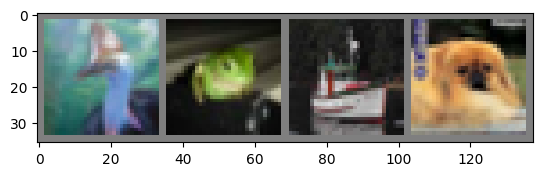

bird  frog  ship  dog  


In [13]:
# Numpy function to show images for verification

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(CIFAR10_trainloader_gen)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{CIFAR10_classes[labels[j]]:5s}' for j in range(batch_size)))


In [4]:
criterion = nn.CrossEntropyLoss()
CIFAR10_optim = optim.Adam(CIFAR10_cnn.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

NameError: name 'CIFAR10_cnn' is not defined

In [1]:
'''
CIFAR10_cnn_test = CIFAR10Cnn(10)

for epoch in range(5):
    e_loss = train(CIFAR10_trainloader_gen, CIFAR10_cnn_test, criterion, CIFAR10_optim, 'cpu')
    print("Epoch", epoch, "loss:", e_loss)
    '''

'\nCIFAR10_cnn_test = CIFAR10Cnn(10)\n\nfor epoch in range(5):\n    e_loss = train(CIFAR10_trainloader_gen, CIFAR10_cnn_test, criterion, CIFAR10_optim, \'cpu\')\n    print("Epoch", epoch, "loss:", e_loss)\n    '

In [ ]:
# Training our base model with 8 classes

for epoch in range(15):
    e_loss = train(no_cat_car_dl, CIFAR10_cnn, criterion, CIFAR10_optim, 'cpu')
    print("Epoch", epoch, "loss:", e_loss)
    
torch.save(CIFAR10_cnn.state_dict(), CIFAR10_model_file)

In [3]:
# Loading general Fashion MNIST trainsets/testsets: https://github.com/zalandoresearch/fashion-mnist

transform = transforms.ToTensor()


FMNIST_train_gen = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=transform)
FMNIST_trainloader_gen = torch.utils.data.DataLoader(FMNIST_train_gen, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

FMNIST_test_gen = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)
FMNIST_testloader_gen = torch.utils.data.DataLoader(FMNIST_test_gen, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

FMNIST_classes = {'T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'}


# Paper leaves out 'Ankle boot' and 'Bag' class, which are indices 8 and 9 respectively
# TODO: clean this up to use the nice subset code

no_boot_bag_train_idx = np.where((np.array(FMNIST_train_gen.targets) != 8) & 
                        (np.array(FMNIST_train_gen.targets) != 9))[0]
no_boot_bag_train_subset = torch.utils.data.Subset(FMNIST_train_gen, no_boot_bag_train_idx)
no_boot_bag_train_dl = torch.utils.data.DataLoader(no_boot_bag_train_subset, batch_size=batch_size, shuffle=True, num_workers=2)

no_boot_bag_test_idx = np.where((np.array(FMNIST_test_gen.targets) != 8) & 
                        (np.array(FMNIST_test_gen.targets) != 9))[0]
no_boot_bag_test_subset = torch.utils.data.Subset(FMNIST_test_gen, no_boot_bag_test_idx)
no_boot_bag_test_dl = torch.utils.data.DataLoader(no_boot_bag_test_subset, batch_size=batch_size, shuffle=True, num_workers=2)

boot_train_idx = np.where((np.array(FMNIST_train_gen.targets) == 8))[0]
boot_train_subset = torch.utils.data.Subset(FMNIST_train_gen, boot_train_idx)
boot_train_dl = torch.utils.data.DataLoader(boot_train_subset, batch_size=batch_size, shuffle=True, num_workers=2)

no_bag_test_idx = np.where((np.array(FMNIST_test_gen.targets) != 9))[0]
no_bag_test_subset = torch.utils.data.Subset(FMNIST_test_gen, no_bag_test_idx)
no_bag_test_dl = torch.utils.data.DataLoader(no_bag_test_subset, batch_size=1, shuffle=True, num_workers=2)

In [4]:
criterion = nn.CrossEntropyLoss()
linear_model = LinearFashionMNIST(8)
FMNIST_optim = optim.Adam(linear_model.parameters(), lr=LEARNING_RATE)

num_epochs = 15

decay_rate = (EXP_DECAY/LEARNING_RATE)**(1/num_epochs)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=FMNIST_optim, gamma=decay_rate) 
# TODO: we need to use the scheduler for cnn too if we use that

In [7]:
# Training our base model with 8 classes

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train(no_boot_bag_train_dl, linear_model, criterion, FMNIST_optim, 'cpu')
    test_loss = test(no_boot_bag_test_dl, linear_model, criterion, 'cpu')
    
    print("Epoch", epoch, "train loss:", train_loss, "test loss:", test_loss)
    
    lr_scheduler.step()
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
print("Finished training, saving to", FNIST_model_no_boot_bag_file)
torch.save(linear_model.state_dict(), FNIST_model_no_boot_bag_file)

loss: 2.088859  [    0/48000]


KeyboardInterrupt: 

In [5]:
# Extracting features from linear model trained on 8 classes

linear_model = LinearFashionMNIST_alt(28*28, 8)

fmnist_file = './weights/linear_fashionmnist_holdout_[8, 9].pt'

linear_model.load_state_dict(torch.load(fmnist_file))
linear_model.eval()

last_layer = 'input_layer'
print("Layer to be extracted:", last_layer)

fnist_feature_ext = FeatureExtractor(linear_model, [last_layer])

Layer to be extracted: input_layer


In [6]:
fmnist_classes = list(range(8)) + [9]

class_subsets, class_idxs, subset_size = generate_dls(FMNIST_train_gen, fmnist_classes)
X, y, subset_size = extract_features(fnist_feature_ext, fmnist_classes, class_subsets, subset_size)
avgs = get_lda_avgs(X, y, subset_size)

In [7]:
sim_scores = get_similarity_vec(avgs)
print(sim_scores)

# this should show that our third-to-last and last values (for sandals and sneakers respectively) are
# most similar to ankle boot (the closer to 0.5 the more similar)

with open(r'./data/fmnist_sim_scores_boot.txt', 'w') as fp:
    for s in sim_scores:
        fp.write("%s\n" % s)

[0.18014976135925553, 0.19696939252588658, 0.16849226502466214, 0.18325411862151122, 0.17034912576975877, 0.3940499752018992, 0.16396360061209814, 0.4110225529609429]


input_size 784
num_outputs 9
[0.09642696907895956, 0.10542984558674412, 0.09018717708527359, 0.09808860748180273, 0.09118108044823336, 0.21091920681806747, 0.08776316397537857, 0.22000394952554073]
[27, 27, 27, 27, 27, 55, 27, 58, 75]
350


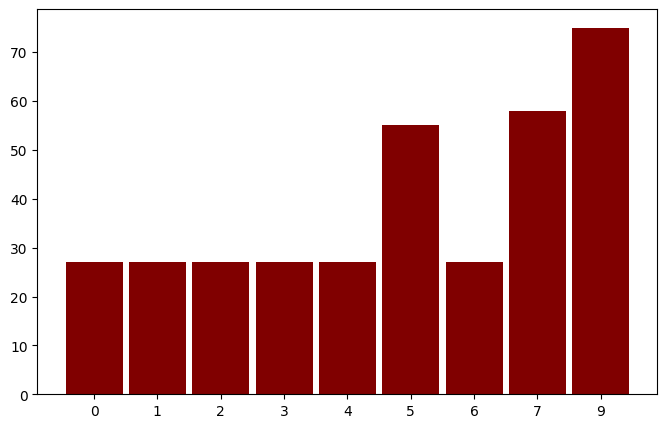

In [8]:
with open(r'./data/fmnist_sim_scores_boot.txt', 'r') as fp:
    sim_scores = [float(i) for i in fp.readlines()]

# Add new class to the linear model
linear_model_new_class = add_output_nodes(fmnist_file)

sim_sum = sum(sim_scores)

sim_norms = [x/sim_sum for x in sim_scores]
print(sim_norms)

# they do this weird thing where the sample size for the boots class is set at 75 and everything not above a certain threshold is set to the same number of samples.
# you can see in the paper (not appendix) this figure, we've mostly approximated it. They also specify N=350 total.
boots_sample_size = 75
sim_sample_sizes = [27 if x < 0.2 else int(x * boots_sample_size*3.52) for x in sim_norms] + [75]
print(sim_sample_sizes)
print(sum(sim_sample_sizes))

fig = plt.figure(figsize = (8, 5))
plt.bar([str(x) for x in fmnist_classes], sim_sample_sizes, color ='maroon', width = 0.9)
plt.show()

In [9]:
# Create a dataloader which contains the samples in the distribution as described above
from random import sample

sampled_idxs = []

for i in range(len(fmnist_classes)):
    idx_sample = sample(class_idxs[i].tolist(), sim_sample_sizes[i])
    sampled_idxs += idx_sample

swil_train_subset = torch.utils.data.Subset(FMNIST_train_gen, sampled_idxs)

swil_train_dl = torch.utils.data.DataLoader(swil_train_subset, batch_size=1, shuffle=True, num_workers=2)

# what to do for testing??

In [10]:
new_model_dict = linear_model_new_class.state_dict()
print(new_model_dict['input_layer.weight'].shape)
print(new_model_dict['input_layer.bias'].shape)
print(new_model_dict['output_layer.weight'].shape)
print(new_model_dict['output_layer.bias'].shape)

model_dict = linear_model.state_dict()
print(model_dict['input_layer.weight'].shape)
print(model_dict['input_layer.bias'].shape)
print(model_dict['output_layer.weight'].shape)
print(model_dict['output_layer.bias'].shape)

torch.Size([128, 784])
torch.Size([128])
torch.Size([9, 128])
torch.Size([9])
torch.Size([128, 784])
torch.Size([128])
torch.Size([8, 128])
torch.Size([8])


In [36]:
def train(dataloader, model, loss_fn, optimizer, device, swap=False, swap_labels=[]) -> float:
    '''
        Model training loop. Performs a single epoch of model updates.
        
        * USAGE *
        Within a training loop of range(num_epochs).

        * PARAMETERS *
        dataloader: A torch.utils.data.DataLoader object
        model: A torch model which subclasses torch.nn.Module
        loss_fn: A torch loss function, such as torch.nn.CrossEntropyLoss
        optimizer: A torch.optim optimizer
        device: 'cuda' or 'cpu'

        * RETURNS *
        float: The model's average epoch loss 
    '''

    size = len(dataloader.dataset)
    train_loss = 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        if swap:
            for i in range(len(y)):
                if y[i] == swap_labels[0]:
                    y[i] = swap_labels[1]
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()
        
        # Compute prediction error
        pred = model(X)

        # Backpropagation
        
        loss = loss_fn(pred, y)
        
        loss.backward()
        optimizer.step()

        # Append lists
        train_loss += loss.item()

        if batch % 1000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return train_loss/len(dataloader)


def test(dataloader, model, loss_fn, device, swap=False, swap_labels=[], classes = 9) -> float:
    '''
        Model test loop. Performs a single epoch of model updates.

        * USAGE *
        Within a training loop of range(num_epochs) to perform epoch validation, or after training to perform testing.

        * PARAMETERS *
        dataloader: A torch.utils.data.DataLoader object
        model: A torch model which subclasses torch.nn.Module
        loss_fn: A torch loss function, such as torch.nn.CrossEntropyLoss
        optimizer: A torch.optim optimizer
        device: 'cuda' or 'cpu'

        * RETURNS *
        float: The average test loss
    '''

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    val_pred = np.array([])
    targets = np.array([])

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            if swap:
                for i in range(len(y)):
                    if y[i] == swap_labels[0]:
                        y[i] = swap_labels[1]
            X, y = X.to(device), y.to(device)
            pred = model(X)
            
            # this is being appended incorrectly
            # val_pred = np.append(val_pred, pred.detach().cpu().numpy()) 
            # targets = np.append(targets, y.detach().cpu().numpy())
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    #print(torch.FloatTensor(val_pred).shape)
    #print(torch.IntTensor(targets).shape)
    
    #recall = Recall(average='macro', num_classes=classes)
    #recall_val = recall(torch.FloatTensor(val_pred), torch.IntTensor(targets))

    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n") #, Recall: {recall_val:>8f} \n")

    return test_loss

In [37]:
for param in linear_model_new_class.parameters():
    param.requires_grad = False
    break

In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(linear_model_new_class.parameters(), lr=LEARNING_RATE)

num_epochs = 15

decay_rate = (EXP_DECAY/LEARNING_RATE)**(1/num_epochs)

lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate) 

model_file = './weights/linear_fashionmnist_holdout_[8].pt'

device = 'cpu'

train_losses = []
test_losses = []
#t = trange(num_epochs)
t = range(num_epochs)

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(swil_train_dl, linear_model_new_class, loss_fn, optimizer, device, swap=True, swap_labels=[9,8])
    test_loss = test(no_bag_test_dl, linear_model_new_class, loss_fn, device, swap=True, swap_labels=[9,8])
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    lr_scheduler.step()
    
torch.save(linear_model_new_class.state_dict(), model_file)
print("Done!")

# need recall, accuracy (are we calculating that now?), cross-entropy loss (same?)

Epoch 1
-------------------------------
loss: 0.000193  [    0/  350]
Test Error: 
 Accuracy: 67.5%, Avg loss: 11.244726 

Epoch 2
-------------------------------
loss: 0.000002  [    0/  350]
Test Error: 
 Accuracy: 67.1%, Avg loss: 11.274290 

Epoch 3
-------------------------------
loss: 0.003963  [    0/  350]
Test Error: 
 Accuracy: 67.4%, Avg loss: 11.261438 

Epoch 4
-------------------------------
loss: 0.000000  [    0/  350]
Test Error: 
 Accuracy: 67.5%, Avg loss: 11.249790 

Epoch 5
-------------------------------
loss: 0.000000  [    0/  350]
Test Error: 
 Accuracy: 67.4%, Avg loss: 11.256776 

Epoch 6
-------------------------------
loss: 0.100319  [    0/  350]
Test Error: 
 Accuracy: 67.6%, Avg loss: 11.284186 

Epoch 7
-------------------------------
loss: 0.000000  [    0/  350]
Test Error: 
 Accuracy: 67.4%, Avg loss: 11.286392 

Epoch 8
-------------------------------
loss: 0.000275  [    0/  350]
Test Error: 
 Accuracy: 66.8%, Avg loss: 11.304566 

Epoch 9
--------

KeyboardInterrupt: 